In [1]:
import graph_tool.all as gt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py # management and storage of large datasets
import os
import shutil
from scipy.stats import poisson
import json
import time
from datetime import datetime
import pandas as pd
import seaborn as sns

## Utility functions

In [2]:
class GraphIO:
    """ A class for imput and output operations on graphs and their metadata
    Attributes:
        base_dir: the parent directory of the experiment
        header_file: txt file containing a short description of the characteristic of the graphs used in the experiment
    
    Methods:
        save_graph()
        save_inferred_graph()
        save_graph_metadata()
        save_dyn_metadata()
        load_metadata()
        filter_graphs()
    """

    def __init__(self, experiment_directory, header_file):
        self.experiment_directory = experiment_directory
        self.base_dir = os.path.join(experiment_directory, 'graphs')
        self.results_dir = os.path.join(experiment_directory, 'results')
        os.makedirs(experiment_directory, exist_ok=True)
        os.makedirs(self.base_dir, exist_ok=True)
        header_path = os.path.join(experiment_directory, 'header.txt')
        if os.path.exists(header_path):
            return
        with open(header_path, "w") as f:
            f.write(header_file)

    def save_graph(self, g: gt.Graph):
        """
        Saves graph in the smallest unused directory within parent directory self.base_dir
        """
        #get the smallest unused index
        existing_dirs = [d for d in os.listdir(self.base_dir) if os.path.isdir(os.path.join(self.base_dir, d))]
        existing_indices = []
        for d in existing_dirs:
            if d.startswith('graph_'):
                try:
                    index = int(d.split('_')[1])
                    existing_indices.append(index)
                except (IndexError, ValueError):
                    continue
        if existing_indices:
            graph_id = min(set(range(1, max(existing_indices) + 2)) - set(existing_indices))
        else:
            graph_id = 1
        #create folder and save
        graph_dir = os.path.join(self.base_dir, f'graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        output_path = os.path.join(graph_dir, 'graph.gt')
        g.save(output_path)
        return graph_id

    def save_graph_metadata(self, graph_id, metadata):
        graph_dir = os.path.join(self.base_dir, f'graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        metadata_path = os.path.join(graph_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load_metadata(self, dir):
        metadata_path = os.path.join(dir, 'metadata.json')
        with open(metadata_path, 'r') as f:
            return json.load(f)

    def filter_graphs(self, nodes: int):
        #return selected graph folder paths
        selected_graphs = []
        for graph_folder in self.list_directories(self.base_dir):
            graph_path = os.path.join(self.base_dir, graph_folder)
            if os.path.isdir(graph_path):
                metadata = self.load_metadata(graph_path)
                graph_nodes = metadata.get('nodes', 0)
                if nodes and nodes != graph_nodes:
                    continue #discard current folder
                selected_graphs.append(graph_folder)
        return selected_graphs

    # Save dynamics metadata
    def save_dyn_metadata(self, metadata: dict, out_dir: str):
        metadata_path = os.path.join(out_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    # Save inferred graph
    def save_inferred_graph(self, g: gt.Graph, dyn_dir_path: str):
        #get the smallest unused index
        existing_dirs = [d for d in os.listdir(dyn_dir_path) if os.path.isdir(os.path.join(dyn_dir_path, d))]
        existing_indices = []
        for d in existing_dirs:
            if d.startswith('inferred_graph_'):
                try:
                    index = int(d.split('_')[2])
                    existing_indices.append(index)
                except (IndexError, ValueError):
                    continue
        if existing_indices:
            graph_id = min(set(range(1, max(existing_indices) + 2)) - set(existing_indices))
        else:
            graph_id = 1
        #create folder and save
        graph_dir = os.path.join(dyn_dir_path, f'inferred_graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        output_path = os.path.join(graph_dir, 'graph.gt')
        g.save(output_path)
        return graph_id

    @staticmethod
    def list_directories(parent_dir)-> list:
        directories = []
        for item in os.listdir(parent_dir):
            item_path = os.path.join(parent_dir, item)
            if os.path.isdir(item_path):
                directories.append(item)
        return directories

class GraphGeneration:
    """
    A class of customized functions for graph generation
    Builts on modules of graph-tool.generation.

    (@staticmethod decorator in Python is used to define a method within a class
    that doesn’t require access to the instance (self) or class (cls) in which
    it’s defined. In other words, a static method is a function that belongs
    to the class, but it doesn’t need to access or modify any instance or 
    class-level attributes. It’s just logically grouped with the class because
    it’s relevant to the class’s functionality. 
    A static method can be called using the class name or an instance of the class)
    """
    @staticmethod
    def poisson_(mu = 5):
        return poisson.rvs(mu)
    ## 1/sqrt(k)
    @staticmethod
    def k_05(kmax = 20):
        accept = False
        while not accept:
            k = np.random.randint(1,kmax+1)
            accept = np.random.random() < 1.0/np.sqrt(k)
        return k
    ## 1/k
    @staticmethod
    def k_1(kmax = 20):
        accept = False
        while not accept:
            k = np.random.randint(1,kmax+1)
            accept = np.random.random() < 1.0/k
        return k
    # SBM
    @staticmethod
    def prob(a, b):
        if a == b:
            return 0.999
        else:
            return 0.001
    @staticmethod
    def sample_sbm(size: int, k: int = 4) -> gt.Graph:
        partitions = np.floor(np.float_power(size, 1/3))
        g, bm = gt.random_graph(size,
                                lambda: GraphGeneration.poisson_(k),
                                directed=False,
                                model="blockmodel",
                                block_membership=lambda: np.random.randint(partitions),
                                edge_probs=GraphGeneration.prob)
        gt.remove_parallel_edges(g)
        gt.remove_self_loops(g)
        return g,bm
    
    # undirected assortative graph (edge is favoured between nodes of similar degree)
    #g = gt.random_graph(1000, lambda: k_1(40), model="probabilistic-configuration",
    #                    edge_probs=lambda i, k: 1.0 / (1 + abs(i - k))**(1/4), directed=False,
    #                    n_iter=100)
    # undirected disassortative graph (edge is favoured between nodes of different degree)
    #g = gt.random_graph(1000, lambda: k_05(40), model="probabilistic-configuration",
    #                    edge_probs=lambda i, k: (1 + abs(i - k)), directed=False,
    #                    n_iter=100)
    #gt.random_rewire(g, model= 'erdos', n_iter= 1)
    
class GraphVisualization:
    """
    A class of methods for basic inspection of graphs
    """
    @staticmethod
    def degree_distribution_plot(g:gt.Graph) ->None:
        degrees = [v.out_degree() for v in g.vertices()]
        unique_degrees, counts = np.unique(degrees, return_counts=True)
        prob_dist = counts / counts.sum()
        plt.figure(figsize=(8, 6))
        plt.plot(unique_degrees, prob_dist, marker='o', linestyle='None', markersize=5, color='b')
        plt.title('Degree Distribution (log-log scale)')
        plt.xlabel('Degree')
        plt.ylabel('Probability')
        plt.grid(True)
        plt.show()

    @staticmethod
    def correlation_plot(g:gt.Graph) -> None:
        plt.figure(figsize=(8,3))
        corr = gt.avg_neighbor_corr(g, "total", "total")
        plt.errorbar(corr[2][:-1], corr[0], yerr=corr[1], fmt="o-",label=r"<k n.n.> vs k")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

# Experiment definition

In [4]:
current_datetime = datetime.now()
header = f"""
    creation date: {current_datetime}
    This folder contains all the data for a performance evaluation of the inference algorithm.
    The algorithm is tested using input data generated from simulated Ising-Glauber dynamics.
    The graphs used in this test are synthetic, undirected, and free of self-loops and multi-edges.
    They are generated from a Stochastic Block Model (SBM) with  N  nodes and approximately  N^{1/3}  partitions.
    The probability of intra-partition connections is 0.999, while the probability of inter-partition connections is 0.001.
    This structure results in partitions that are highly likely to form disjoint connected components.
    The mean degree is set to k_mean = 4.
    The Ising dynamics is simulated for a fixed value of the inverse temperature beta = 1.
    The graphs is given uniform weights = 1/ k_mean. This combination of weights and inverse temperature
    results in a partially ordered regime for the Ising dynamics, thus enabling inference.
"""
giom = GraphIO(experiment_directory= 'experiment_small_graphs', header_file= header)

## Graph generation (SBM)

In [13]:
def define_metadata(g: gt.Graph) -> dict:
    k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
    current_datetime = datetime.now()
    metadata = {
        "graph_type": "SBM",
        "nodes": g.num_vertices(),
        "edges": g.num_edges(),
        "directed": "false",
        "degree_distribution": "poisson",
        "power_law_exponent": "null",
        "mean_degree": k_mean,
        "edge_density": 2 * g.num_edges() / (g.num_vertices() ** 2),
        "correlations": "false",
        "weight": 1 / k_mean,
        "creation_date": current_datetime.isoformat()
    }
    return metadata


graph_sizes = [n * 5 for n in range(2, 20)]

for size in graph_sizes:
    print(f"size: {size}")
    g,bm = GraphGeneration.sample_sbm(size = size)
    k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
    w = g.new_edge_property("double", vals= [1./k_mean])
    g.ep["weights"] = w
    idx = giom.save_graph(g)
    gt.graph_draw(g, vertex_fill_color = bm, output=os.path.join(giom.base_dir, f'graph_{idx}', 'visualization.pdf'))
    giom.save_graph_metadata(graph_id=idx, metadata = define_metadata(g))

size: 10
size: 15
size: 20
size: 25
size: 30
size: 35
size: 40
size: 45
size: 50
size: 55
size: 60
size: 65
size: 70
size: 75
size: 80
size: 85
size: 90
size: 95


## Dynamics generation

In [14]:
dynamics_name = 'IsingGlauber'
M = 1000

graph_folders = giom.list_directories(giom.base_dir)

if graph_folders:
    for i, graph_folder in enumerate(graph_folders):


        print(f"opening {graph_folder}")
        dyn_folder_path = os.path.join(giom.base_dir, graph_folder, dynamics_name)
        # If a dynamics was already simulated for the graph,skip the graph

        if os.path.exists(dyn_folder_path) and os.path.isdir(dyn_folder_path):
            print(f"skipping {graph_folder}")
            continue

        input_path = os.path.join(giom.base_dir, graph_folder, 'graph.gt')
        g_new = gt.load_graph(input_path)
        k_mean = sum(g_new.degree_property_map("total").a)/ g_new.num_vertices()
        
        start_time = time.time()
        istate = gt.IsingGlauberState(g_new, w= 1./k_mean)
        X = []
        for m in range(M):
            istate.iterate_sync()
            X.append(istate.get_state().a.copy())
        X = np.array(X).T # N rows, M columns
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"simulated dynamics {X.shape} in : {execution_time} seconds")

        all_valid_values = np.isfinite(X).all()
        if not all_valid_values:
            print("Invalid values. Dynamics not saved. Continue to next graph")
            continue
        # Save
        out_dir = os.path.join(giom.base_dir, graph_folder, dynamics_name)
        os.makedirs(out_dir, exist_ok=True)
        output_path = os.path.join(out_dir, 'dynamics.h5')
        with h5py.File(output_path, 'w') as hf:
            hf.create_dataset('dataset_name', data=X)

        current_datetime = datetime.now()
        metadata = {
            'dynamics': dynamics_name,
            'nodes': g_new.num_vertices(),
            'samples': M,
            'execution_time': execution_time,
            'weights': 1./k_mean,
            'beta': 1,
            'h': 0,
            'initial_state': 'random',
            'creation_date': current_datetime.strftime("%d-%m-%Y/%H:%M:%S")
        }
        giom.save_dyn_metadata(metadata= metadata, out_dir=out_dir)   

opening graph_14
skipping graph_14
opening graph_13
skipping graph_13
opening graph_25
simulated dynamics (40, 1000) in : 0.00631403923034668 seconds
opening graph_22
simulated dynamics (25, 1000) in : 0.004397869110107422 seconds
opening graph_23
simulated dynamics (30, 1000) in : 0.00419306755065918 seconds
opening graph_24
simulated dynamics (35, 1000) in : 0.004046916961669922 seconds
opening graph_12
skipping graph_12
opening graph_15
skipping graph_15
opening graph_7
skipping graph_7
opening graph_9
skipping graph_9
opening graph_8
skipping graph_8
opening graph_6
skipping graph_6
opening graph_1
skipping graph_1
opening graph_30
simulated dynamics (65, 1000) in : 0.004427194595336914 seconds
opening graph_31
simulated dynamics (70, 1000) in : 0.0044040679931640625 seconds
opening graph_36
simulated dynamics (95, 1000) in : 0.004745006561279297 seconds
opening graph_10
skipping graph_10
opening graph_17
skipping graph_17
opening graph_28
simulated dynamics (55, 1000) in : 0.00359

## Inference

In [19]:
dynamics_name = 'IsingGlauber'
M = 500
equilibrium = False

folders = giom.list_directories(parent_dir= giom.base_dir)
for graph_folder in folders:
    
    # Load original graph
    graph_path = os.path.join(giom.base_dir, graph_folder, 'graph.gt')
    g = gt.load_graph(graph_path)
    # Skip large graphs
    if g.num_vertices() > 50:
        continue
    w = g.ep.weights
    print("-------------------------------------")
    print()
    print(f"loaded {graph_folder} with nodes {g.num_vertices()}")
    """
    Load the dynamics. 
    For large dataset it is crucial that the subset of samples is selected 
    directly from the HDF5 file without loading the full dataset first.
    """
    dyn_folder_path = os.path.join(giom.base_dir, graph_folder, dynamics_name)
    if not os.path.isdir(dyn_folder_path):
        continue
    # Check if dynamics is already inferred with M samples
    # If so, skip the inference
    directories = giom.list_directories(dyn_folder_path)
    inferred = False
    if directories:
        for d in directories:
            metadata = giom.load_metadata(os.path.join(dyn_folder_path, d))
            if metadata.get('samples', 0) == M:
                inferred = True
    if inferred:
        print(f"Graph {graph_folder} already inferred with {M} samples")
        continue
    file_path = os.path.join(dyn_folder_path, 'dynamics.h5')
    with h5py.File(file_path, 'r') as hf:
        dataset = hf['dataset_name']
        total_samples = dataset.shape[1] 
        M = min(M, total_samples) #valid range
        if not equilibrium:
            selected_samples = sorted(np.random.choice(total_samples, size=M, replace=False))
        else:
            selected_samples = np.arange(total_samples - M, total_samples)
        X = dataset[:, selected_samples]
    print(f"loaded data matrix: {X.shape}")
    
    # Inference
    start_time = time.time()
    print("Inference started:")
    if not equilibrium:
        state = gt.IsingGlauberBlockState(X)
    else:
        state = gt.PseudoIsingBlockState(X)
    delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
    print(delta)
    iter = 0
    while np.abs(delta) > 0.00001 and iter < 10:
        iter += 1
        delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
    u = state.get_graph()      # reconstructed network
    w_r = state.get_x()        # reconstructed weights
    t_r = state.get_theta()    # reconstructed thetas
    end_time = time.time()
    execution_time = end_time - start_time

    # Save inferred graph and metadata in 
    # gt_performance_test/experiment_directory/graphs/graph_idx/dynamics_name/inferred_graph_idx/...
    idx = giom.save_inferred_graph(g = u, dyn_dir_path=dyn_folder_path)
    current_datetime = datetime.now()
    if not equilibrium:
        model_name = 'IsingGlauberBlockState'
    else:
        model_name = 'PseudoIsingBlockState'
    metadata = {
        'model': model_name,
        'nodes': u.num_vertices(),
        'edges': u.num_edges(),
        'samples': M,
        'jaccard_unweighted': gt.similarity(g, u),
        'jaccard_weighted': gt.similarity(g, u, g.edge_properties.weights, w_r),
        'runtime': execution_time,
        'creation_date': current_datetime.strftime("%d-%m-%Y/%H:%M:%S")
    }
    out_dir = os.path.join(dyn_folder_path, f"inferred_graph_{idx}")
    os.makedirs(out_dir, exist_ok=True)
    metadata_path = os.path.join(out_dir, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    # Print results
    print(f"done {graph_folder} in : {execution_time} seconds")
    print(f"True network: number of nodes {g.num_vertices()}, number of edges= {g.num_edges()}")
    print(f"Inferred network: number of nodes {u.num_vertices()}, number of edges= {u.num_edges()}")
    print(f"Weighted similarity: {gt.similarity(g, u, w, w_r)}")
    print(f"Unweighted similarity: {gt.similarity(g, u)}")

-------------------------------------

loaded graph_25 with nodes 40
loaded data matrix: (40, 500)
Inference started:
-1116.5924080774068
done graph_25 in : 27.580261945724487 seconds
True network: number of nodes 40, number of edges= 76
Inferred network: number of nodes 40, number of edges= 89
Weighted similarity: 0.6430780720786181
Unweighted similarity: 0.8242424242424242
-------------------------------------

loaded graph_22 with nodes 25
loaded data matrix: (25, 500)
Inference started:
-998.0055592489688
done graph_22 in : 15.8035249710083 seconds
True network: number of nodes 25, number of edges= 57
Inferred network: number of nodes 25, number of edges= 57
Weighted similarity: 0.6992492415885418
Unweighted similarity: 0.8421052631578947
-------------------------------------

loaded graph_23 with nodes 30
loaded data matrix: (30, 500)
Inference started:
-985.3520529933435
done graph_23 in : 16.233264923095703 seconds
True network: number of nodes 30, number of edges= 72
Inferred n

## Visualize results

In [8]:
"""
Plot a visualization of the original graph and the inferred graph
"""
graph_folder = os.path.join(giom.base_dir, "graph_4")
graph_path = os.path.join(graph_folder, 'graph.gt')
inferred_graph_path = os.path.join(graph_folder, "IsingGlauber", "inferred_graph_1", "graph.gt")
g = gt.load_graph(graph_path)
u = gt.load_graph(inferred_graph_path)

# Draw results
plt.switch_backend("cairo")
fig, ax = plt.subplots(1,2)
lay = gt.sfdp_layout(g)

gt.graph_draw(g, pos= lay, edge_color = 'black', vertex_color = 'black', vertex_fill_color = 'gray', mplfig = ax[0]).fit_view(yflip=True)


common_edges = [e for e in u.edges() if g.edge(e.source(), e.target())]
edge_colors = u.new_edge_property("string")
for e in u.edges():
    if e in common_edges:
        edge_colors[e] = "black"
    else:
        edge_colors[e] = "red"


gt.graph_draw(u, pos=lay, mplfig=ax[1], vertex_color = 'black', vertex_fill_color = 'gray', edge_color=edge_colors).fit_view(yflip=True)

for a in ax:
    a.set_xticks([])  # Remove x ticks
    a.set_yticks([])  # Remove y ticks

ax[0].set_title(f"True graph E= {g.num_edges()}")
ax[1].set_title(f"Inferred graph E= {u.num_edges()}")
fig.savefig("prova.pdf")

In [5]:
"""
Create output csv file with the name given by variable 'filename'
with columns: nodes,true_edges,samples,inferred_edges,jaccard_unweighted,jaccard_weighted, runtime
"""
dynamics_name = 'IsingGlauber'
dynamics_regime = "eq" # alternative: "non_eq"

if dynamics_regime == "eq":
    inference_model_name = 'PseudoIsingBlockState' #class object used for inference
    folder_path = os.path.join(giom.experiment_directory, "inference_results", "eq") # folder where output will be saved
    os.makedirs(folder_path, exist_ok= True)

if dynamics_regime == "non_eq":
    inference_model_name = 'IsingGlauberBlockState' #class object used for inference
    folder_path = os.path.join(giom.experiment_directory, "inference_results", "eq") # folder where output will be saved
    os.makedirs(folder_path, exist_ok= True)

filename = "results.csv"
mode = 'w' #['a':'append', 'w': write']
insert_header = (mode == 'w')
# if mode == 'w', overwrite and insert heading.
# if mode == 'a', append to existing file. If does not exist, create new file but without heading.
file_path = os.path.join(folder_path, filename)


results = []
graph_folders = giom.list_directories(giom.base_dir)
for folder in graph_folders:

    nodes = 0
    true_edges = 0
    samples = 0
    inferred_edges = 0
    jaccard_unweighted = 0
    jaccard_weighted = 0
    runtime = 0

    dyn_folder_path = os.path.join(giom.base_dir, folder, dynamics_name)
    if os.path.isdir(dyn_folder_path) and os.path.exists(os.path.join(dyn_folder_path, 'dynamics.h5')):
        inferred_graph_dirs = [d for d in os.listdir(dyn_folder_path) if os.path.isdir(os.path.join(dyn_folder_path, d)) and d.startswith('inferred_graph')]
    
    if len(inferred_graph_dirs) == 0:
        continue

    # Load original graph metadata
    metadata = giom.load_metadata(dir= os.path.join(giom.base_dir, folder))
    nodes = metadata["nodes"]
    true_edges = metadata['edges']

    # Load inferred graph metadata
    for inferred_graph in inferred_graph_dirs:
        inferred_graph_path = os.path.join(dyn_folder_path, inferred_graph)
        try:
            metadata = giom.load_metadata(dir = inferred_graph_path)
            #try to get the entry at key 'model' and return 'unknown' if no such key is found
            model_name = metadata.get('model', 'unknown')
            inferred_edges = metadata['edges']
            samples = metadata['samples']
            jaccard_unweighted = metadata['jaccard_unweighted']
            jaccard_weighted = metadata['jaccard_weighted']
            runtime = metadata['runtime']
        except FileNotFoundError:
            print(f"Error: File metadata not found for {inferred_graph_path}")
        except KeyError as e:
            print(f"Error: Missing key {e} in metadata for {inferred_graph_path}")
        
        if model_name == inference_model_name:
            results.append({
                    'nodes': nodes,
                    'true_edges': true_edges,
                    'samples' : samples,
                    'inferred_edges' : inferred_edges,
                    'jaccard_unweighted' : jaccard_unweighted,
                    'jaccard_weighted' : jaccard_weighted,
                    'runtime': runtime
                    })
       
df = pd.DataFrame(results)
df.sort_values(by=['nodes', 'samples'], ascending=[True, True], inplace=True)
print(df.head())

with open(file_path, mode=mode, newline='') as f:
    df.to_csv(f, index=True, header= insert_header)

   nodes  true_edges  samples  inferred_edges  jaccard_unweighted  \
4     10          15      100               6            0.190476   
3     10          15      500              16            0.451613   
0     10          15     1000              16            0.516129   
5     10          15     2000              16            0.516129   
2     10          15     3000              17            0.562500   

   jaccard_weighted    runtime  
4          0.175238   0.411514  
3          0.342703   3.246917  
0          0.332775  10.309184  
5          0.328532  12.643773  
2          0.328643  17.062813  


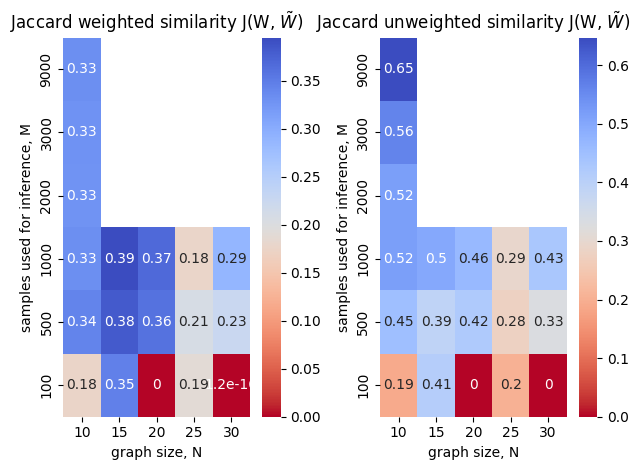

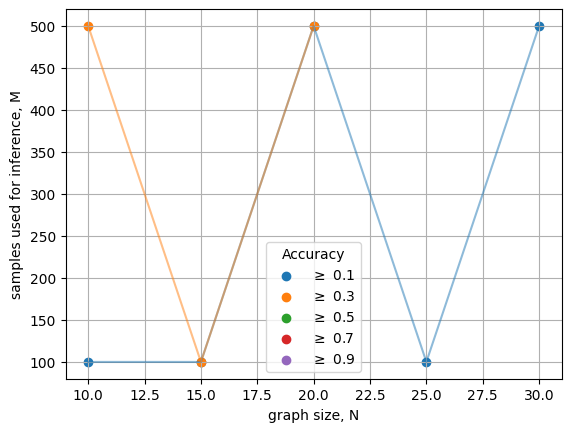

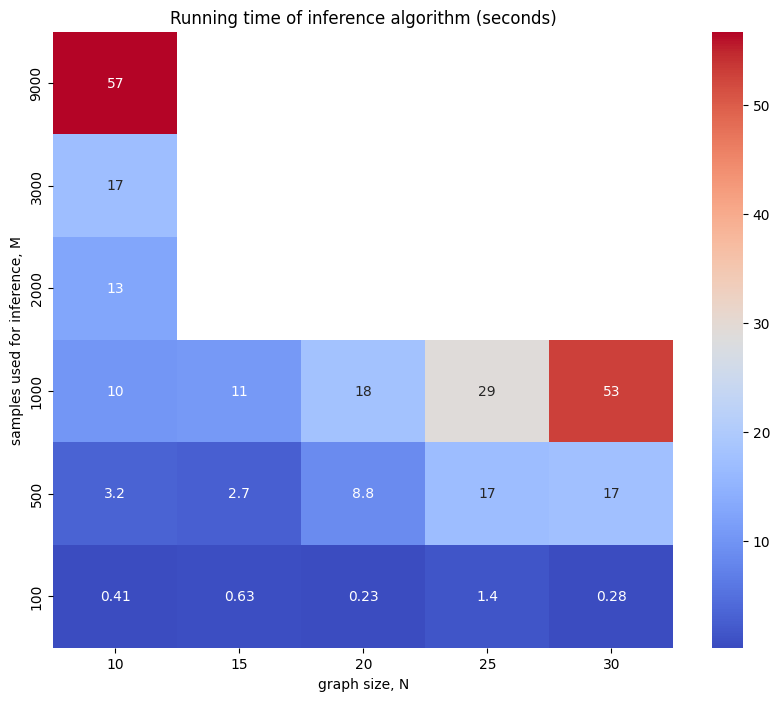

In [11]:
"""
Reads data from a CSV file (input_filename) and generates 3 visualizations:
Heatmap: Displays the Jaccard weighted similarity (accuracy) as a function of graph size (nodes)
        and sample size.
Multi-line Plot: Illustrates the minimum number of samples required to achieve specific accuracy levels across varying graph sizes. 
        For each accuracy threshold, the plot displays the minimum sample count for each graph size.

Both plots are saved as PDF files in the specified output paths.
"""

dynamics_regime = "eq" # alternative: "non_eq"
input_filename = 'results.csv'

heatmap_filename = 'heatmap.pdf'
multiline_filename = 'multiline.pdf'
time_filename = 'time.pdf'


if dynamics_regime == "eq":
    folder_path = os.path.join(giom.experiment_directory, "inference_results", "eq") # folder containing input and output
    
if dynamics_regime == "non_eq":
    folder_path = os.path.join(giom.experiment_directory, "inference_results", "non_eq") # folder containing input and output

# Read input file
df = pd.read_csv(os.path.join(folder_path, input_filename))


# Heatmap
fig, ax = plt.subplots(nrows=1, ncols=2)
# weighted similarity
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='jaccard_weighted', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", cbar=True, ax = ax[0])
ax[0].set_title(r'Jaccard weighted similarity J(W, $\tilde{W}$)')
ax[0].set_xlabel('graph size, N')
ax[0].set_ylabel('samples used for inference, M')
ax[0].invert_yaxis()
# unweighted similarity
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='jaccard_unweighted', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", cbar=True, ax = ax[1])
ax[1].set_title(r'Jaccard unweighted similarity J(W, $\tilde{W}$)')
ax[1].set_xlabel('graph size, N')
ax[1].set_ylabel('samples used for inference, M')
ax[1].invert_yaxis()
plt.savefig(os.path.join(folder_path, heatmap_filename))
plt.tight_layout()

# Multiline
accuracy_levels = [0.1* c for c in range(1, 10, 2)]
fig, ax = plt.subplots()
for acc in accuracy_levels:
    temp = df[df['jaccard_weighted'] >= acc]
    grouped_data = temp.groupby('nodes', as_index=False)['samples'].min()
    ax.scatter(grouped_data['nodes'], grouped_data['samples'], label= rf"$\geq$ {acc:.1f}")
    ax.plot(grouped_data['nodes'], grouped_data['samples'], alpha = 0.5)
ax.set_xlabel('graph size, N')
ax.set_ylabel('samples used for inference, M')
ax.grid()
plt.legend(title= "Accuracy")
plt.savefig(os.path.join(folder_path, multiline_filename))

# Time heatmap
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='runtime', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True)
plt.gca().invert_yaxis()
plt.title(r'Running time of inference algorithm (seconds)')
plt.xlabel('graph size, N')
plt.ylabel('samples used for inference, M')
plt.savefig(os.path.join(folder_path, time_filename))
